In [1]:
from mxnet import ndarray as nd
from mxnet import autograd as ag

num_input = 2
num_examples = 1000

true_w = [1.5, -3.5]
true_b = 5.2

X = nd.random_normal(shape = (num_examples, num_input))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(shape = y.shape)  #add noise

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
print(X[0], y[0])


[ 0.30030754  0.23107235]
<NDArray 2 @cpu(0)> 
[ 4.82760286]
<NDArray 1 @cpu(0)>


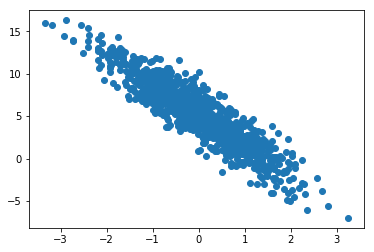

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

Data Input

In [4]:
import random
batch_size = 10
def data_iter():
    # generate a random index
    idx = list(range(num_examples))
#     print(idx)
    random.shuffle(idx)
#     print(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i : min(i + batch_size, num_examples)])
        yield nd.take(X, j), nd.take(y, j)

In [5]:
for data, label in data_iter():
    print(data, label)
    break


[[-0.12730747  0.17334919]
 [ 0.83432126 -0.30592811]
 [ 0.92054403  0.18530124]
 [ 0.78584474 -0.03065837]
 [-0.04056321 -1.42404068]
 [ 2.59055066  1.94307101]
 [ 0.15614767  0.40446803]
 [-1.43397725 -1.10425019]
 [ 0.42437807  0.7583164 ]
 [-0.73735899 -0.36703965]]
<NDArray 10x2 @cpu(0)> 
[  4.38836288   7.52968788   5.92589045   6.48992252  10.1248188
   2.2852087    4.01520395   6.92703199   3.16903543   5.37377787]
<NDArray 10 @cpu(0)>


Parameters Initialization

In [6]:
w = nd.random_normal(shape = (num_input, 1))
b = nd.zeros((1,))
params = [w, b]

In [7]:
for param in params:
    param.attach_grad()

Model

In [8]:
def net(X):
    return nd.dot(X, w) + b

Loss Function

In [9]:
def square_loss(yhat, y):
    # transfer y to the shape of yhat to avoid  matrix shape autotransfer(broadcasting)
    return (yhat - y.reshape(yhat.shape)) ** 2

Optimize Method

In [10]:
def SGD(params, lr):
    for param in params:
        param[:]  = param - lr * param.grad  # x[:] = x + y or x += y can reduce space cost

Train

In [11]:
# model function
def real_fn(X):
    return true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
#plot loss decent by trainning times graphic and prediction-real_value scatter diagram
def plot(losses, X, sample_size =  100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
            net(X[:sample_size, :]).asnumpy(), 'or', label = 'Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
            real_fn(X[:sample_size, :]).asnumpy(), '*g', label = 'Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 8.85402913143. Avarage loss: 11.573060


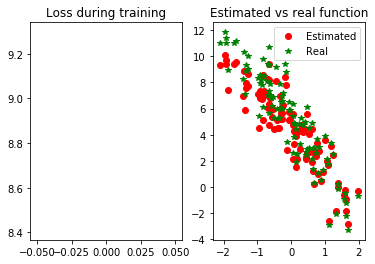

Epoch 1, batch 199. Moving avg of loss: 2.46395121318. Avarage loss: 0.183762


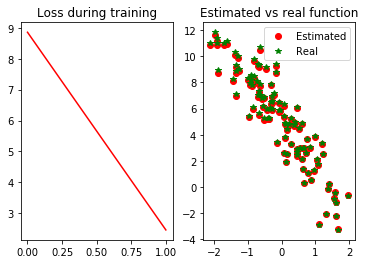

Epoch 2, batch 299. Moving avg of loss: 0.82204224346. Avarage loss: 0.003013


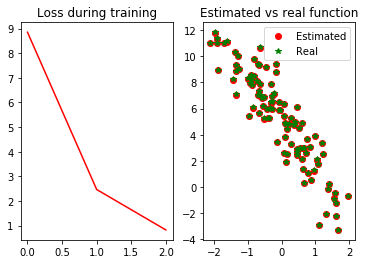

Epoch 3, batch 399. Moving avg of loss: 0.291353991256. Avarage loss: 0.000138


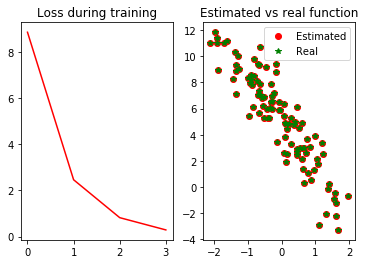

Epoch 4, batch 499. Moving avg of loss: 0.105470374984. Avarage loss: 0.000092


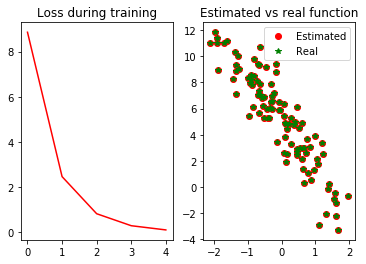

In [12]:
epochs = 5
learning_rate = .001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = .01

# training
for e in range(epochs):
    total_loss = 0
    for data, label in data_iter():
        with ag.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()
        
        # recording the change of loss moving mean when reading a data point
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        
        # correct the bias from the moving average
        est_loss = moving_loss / (1 - (1- smoothing_constant) ** niter)
        
        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print('Epoch %s, batch %s. Moving avg of loss: %s. Avarage loss: %f' % (e, niter, est_loss, total_loss / num_examples))
            plot(losses, X)

In [13]:
print(params)

[
[[ 1.49979937]
 [-3.49985218]]
<NDArray 2x1 @cpu(0)>, 
[ 5.20002747]
<NDArray 1 @cpu(0)>]


In [14]:
true_w, w

([1.5, -3.5], 
 [[ 1.49979937]
  [-3.49985218]]
 <NDArray 2x1 @cpu(0)>)

In [15]:
true_b, b

(5.2, 
 [ 5.20002747]
 <NDArray 1 @cpu(0)>)